In [327]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import itertools # Importando itertools para generar combinaciones de columnas
# Importando la función seasonal_decompose para la descomposición de series temporales
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.patches as mpatches
import payments_manager as pm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
# Importa la función para crear la matriz de confusión
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
cr_cp = pm.df('cr_cp')
fe_cp = pm.df('fe_cp')
df_jo = pm.df('df_jo')
#df_jo = pm.sort("df_jo", ["id_cr"]).reset_index()
#df_jo = df_jo.drop(columns=['index'])
#df_jo = df_jo.drop(columns=['Mes_created_at'])
#df_jo_cp = df_jo.copy()
df_jo = pm.sort("df_jo", ["id_cr"]).reset_index()
df_jo = df_jo.drop(columns=['index'])
#df_jo.info()
#

,amount,fee,n_backs,n_fees,n_recovery,n_incidents,transfer_type_regular,charge_moment_before,category_nice,category_rejected_direct_debit
0,1.0,0.0,0,0,0,1,1,0,0,0
1,100.0,0.0,1,0,0,0,1,0,0,0


                      Predictores  Mínimo  Máximo      Media    Varianza
0                          amount     1.0   200.0  83.516733  670.817837
1                             fee     0.0    10.0   3.280568    5.642271
2                         n_backs     0.0    11.0   1.459491    1.941803
3                          n_fees     0.0    15.0   0.978375    1.269070
4                      n_recovery     0.0    28.0   0.711143    2.896494
5                     n_incidents     0.0    33.0   1.887386    7.349028
6           transfer_type_regular     0.0     1.0   0.392746    0.238497
7            charge_moment_before     0.0     1.0   0.135112    0.116856
8                   category_nice     0.0     1.0   0.587685    0.242311
9  category_rejected_direct_debit     0.0     1.0   0.049794    0.047315
Dimensiones de X_train: (25673, 10), X_test: (6419, 10)
Dimensiones de y_train: (25673,), y_test: (6419,)


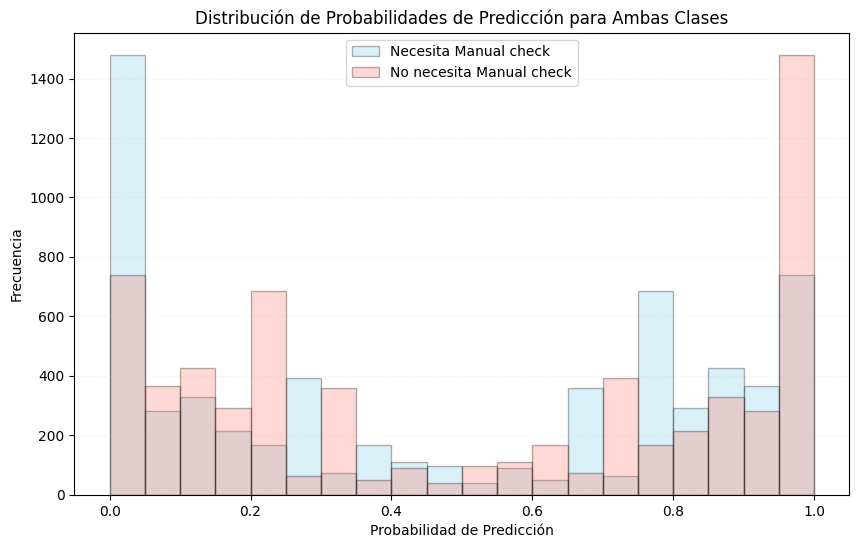

predicciones_probabilidades:
 [[0.78587066 0.21412934]
 [0.05298498 0.94701502]
 [0.16607814 0.83392186]
 [0.99489876 0.00510124]
 [0.02453919 0.97546081]
 [0.51859723 0.48140277]
 [0.61735037 0.38264963]
 [0.00281757 0.99718243]
 [0.09949908 0.90050092]
 [0.67224387 0.32775613]]

Coeficientes del modelo de regresión logística (ordenados por magnitud):
category_nice: -3.0101
category_rejected_direct_debit: 2.7217
n_recovery: 1.5829
n_fees: -1.4533
transfer_type_regular: -1.0641
charge_moment_before: 1.0376
n_incidents: 0.9187
n_backs: -0.8399
fee: 0.5564
amount: 0.0122


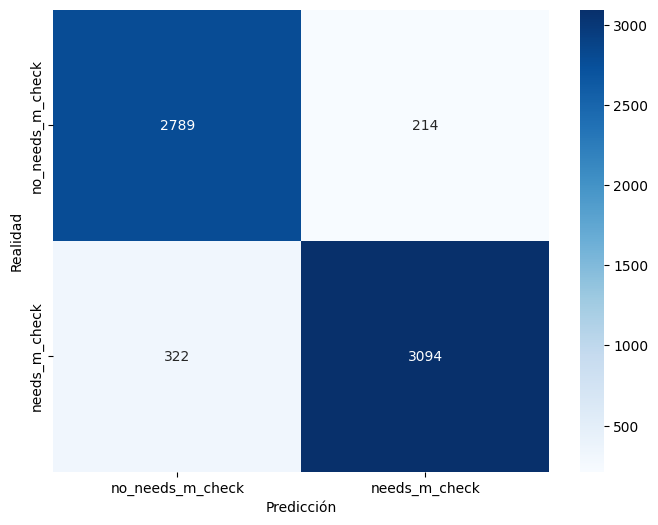

Accuracy: 0.9164978968686711
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.93      0.91      3003
           1       0.94      0.91      0.92      3416

    accuracy                           0.92      6419
   macro avg       0.92      0.92      0.92      6419
weighted avg       0.92      0.92      0.92      6419



In [328]:
df = df_jo.copy()
# Convertir columnas datetime a timestamps
for col in df.select_dtypes(include=['datetime64']).columns:
    df[col] = df[col].apply(lambda x: x.timestamp() if pd.notnull(x) else None)

for col in df.select_dtypes(include=['timedelta64']).columns:
    df[col] = df[col].apply(lambda x: x / pd.to_timedelta(1, unit='d') if pd.notnull(x) else None)

#df['moderada'] = df['moderated_at'].apply(lambda x: 1 if not pd.isnull(x) else 0)

# Variables predictoras (ajusta según los datos disponibles)
columnas = ['amount','fee', 'transfer_type', 'charge_moment', 'category','n_backs','n_fees','n_recovery','n_incidents']
            #'reimbursement_date','to_reimbur', 'GBP_EUR','inflation','BTC_GBP','unemploy_rate'] # 'stat_cr','stat_fe', 'recovery_status'
X = df[columnas].copy()
# Categoricas
X = pd.get_dummies(X, columns=['transfer_type','charge_moment', 'category'], drop_first=True, dtype=int)

y = df['needs_m_check_recov'].copy()  #moderada # La columna de la variable objetivo

# # Crear el escalador
# display(X.head(1))
# scaler = StandardScaler()
# # Estandarizar todas las columnas
# normalizado = scaler.fit_transform(X)
# # Convertir de nuevo a DataFrame, preservando nombres de columnas e índices
# X = pd.DataFrame(normalizado, columns=X.columns, index=df.index)
# X.fillna(0, inplace=True)
# #X.info()

display(X.head(2))
feature_names=X.columns
X_stat= X.copy().to_numpy()
# Crear una lista para almacenar los resultados
resultados = []

# Iterar sobre los predictores y calcular las estadísticas
for i, feat in enumerate(feature_names):
    minimo = np.min(X_stat[:, i])
    maximo = np.max(X_stat[:, i])
    media = np.mean(X_stat[:, i])
    varianza = np.var(X_stat[:, i])
    # Añadir los resultados a la lista
    resultados.append([feat, minimo, maximo, media, varianza])

# Crear un DataFrame para mostrar los resultados
df_estadisticas = pd.DataFrame(resultados, columns=['Predictores', 'Mínimo','Máximo', 'Media', 'Varianza'])
# Mostrar el DataFrame
print(df_estadisticas)

#feature_names = X.columns # Obtener los nombres de las características
# Dividir el conjunto en datos de entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)
# Verificar las dimensiones de los conjuntos de entrenamiento y prueba
print('Dimensiones de X_train: {}, X_test: {}'.format(X_train.shape, X_test.shape))
print('Dimensiones de y_train: {}, y_test: {}'.format(y_train.shape, y_test.shape))

# Crea el clasificador de regresión logística. El 'liblinear' usa metodo de optimización de minimos cuadrados generalizados (L2) y soporta la regularización L1 y L2
clf = LogisticRegression(solver="liblinear") # solver="liblinear" puede ser ineficiente si tienes muchas variables o datos. Se puede usar saga o lbfgs en estos casos.
clf.fit(X_train, y_train) # Entrena el clasificador
predicciones = clf.predict(X_test) # Realiza predicciones sobre el conjunto de prueba

# Genera las probabilidades de predicción
predicciones_probabilidades = clf.predict_proba(X_test)

# Crea un histograma de las probabilidades de predicción para ambas clases
plt.figure(figsize=(10, 6)) 
plt.hist(predicciones_probabilidades[:, 0], bins=20, color="skyblue", edgecolor="black", alpha=0.3, label="Necesita Manual check")
# Histograma para la clase positiva (no need manual check)
plt.hist(predicciones_probabilidades[:, 1], bins=20, color="salmon", edgecolor="black", alpha=0.3, label="No necesita Manual check")
# Título y etiquetas de los ejes
plt.title("Distribución de Probabilidades de Predicción para Ambas Clases")
plt.xlabel("Probabilidad de Predicción")
plt.ylabel("Frecuencia")
plt.legend(loc="upper center") 
# Muestra la leyenda en el gráfico
plt.grid(axis="y", linestyle="--", alpha=0.1)
plt.show()

# Muestra las primeras 10 probabilidades de predicción
print(f"predicciones_probabilidades:\n {predicciones_probabilidades[:10]}\n")

# Obtén los coeficientes y asigna los nombres de las características
coeficientes = clf.coef_[0]  # clf.coef_ es un array bidimensional, tomamos la primera fila
feature_coef = list(zip(feature_names, coeficientes))

# Ordena las características por el valor absoluto del coeficiente en orden descendente
feature_coef_sorted = sorted(feature_coef, key=lambda x: abs(x[1]), reverse=True)

# Imprime cada variable junto con su coeficiente ordenado
print("Coeficientes del modelo de regresión logística (ordenados por magnitud):")
for feature, coef in feature_coef_sorted:
    print(f"{feature}: {coef:.4f}")

# Genera la matriz de confusión
matriz_confusion = confusion_matrix(y_test, predicciones)
columnas = ['no_needs_m_check', 'needs_m_check'] # 0 para No necesita manual check y 1 para Sí necesita manual check

# Visualiza la matriz de confusión utilizando un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', xticklabels=columnas, yticklabels=columnas)
plt.xlabel("Predicción")
plt.ylabel("Realidad")
plt.show()
# Evaluate model performance
print("Accuracy:", clf.score(X_test, y_test))  # Accuracy score
print("Classification Report:\n", classification_report(y_test, predicciones))  # Classification report    

In [329]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Realizar predicciones sobre el conjunto de prueba
y_test_pred = clf.predict(X_test)
y_train_pred = clf.predict(X_train) # Predicciones sobre el conjunto de entrenamiento

In [330]:
#Evaluar el modelo utilizando métricas de desempeño
mse_train = mean_squared_error(y_train, y_train_pred) # Error cuadrático medio para entrenamiento
mse_test = mean_squared_error(y_test, y_test_pred) # Error cuadrático medio para prueba
r2score_train = clf.score(X_train, y_train) # Puntaje R^2 en entrenamiento
r2score_test = clf.score(X_test, y_test) # Puntaje R^2 en prueba
# Mostrar el intercepto y los coeficientes del modelo
print('Intercepto y coeficientes del modelo:\n \nIntercepto: {}\n\nCoeficientes: {}'.format(clf.intercept_, clf.coef_))
# Mostrar el error cuadrático medio y el puntaje R^2
print('\nError Cuadrático Medio (ECM) en entrenamiento: {}'.format(mse_train))
print('Error Cuadrático Medio (ECM) en prueba: {}'.format(mse_test))
print('\nPuntaje R^2 en entrenamiento: {}'.format(r2score_train))
print('Puntaje R^2 en prueba: {}'.format(r2score_test))

Intercepto y coeficientes del modelo:
 
Intercepto: [-0.00144262]

Coeficientes: [[ 0.01222644  0.55637335 -0.83986851 -1.45333988  1.58290601  0.91872607
  -1.0641198   1.03761692 -3.01007192  2.72168706]]

Error Cuadrático Medio (ECM) en entrenamiento: 0.08440774354380089
Error Cuadrático Medio (ECM) en prueba: 0.08350210313132887

Puntaje R^2 en entrenamiento: 0.9155922564561991
Puntaje R^2 en prueba: 0.9164978968686711


In [331]:
# Obtener los coeficientes de regresión
display(feature_names)
coefs_clf = pd.Series(np.abs(clf.coef_[0]), index=feature_names).sort_values() # Valores absolutos para ordenarlos

Index(['amount', 'fee', 'n_backs', 'n_fees', 'n_recovery', 'n_incidents',
       'transfer_type_regular', 'charge_moment_before', 'category_nice',
       'category_rejected_direct_debit'],
      dtype='object')

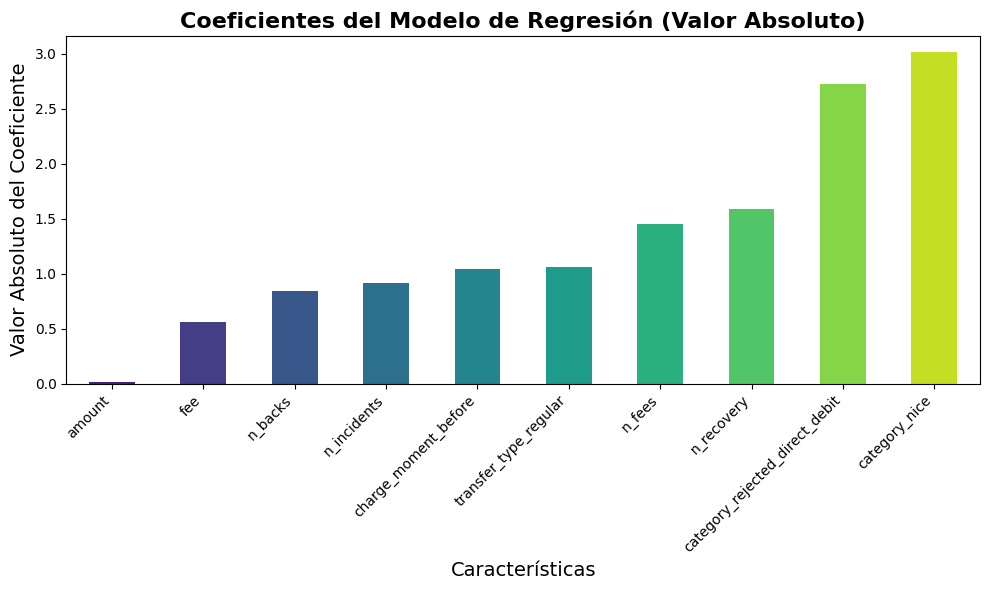

In [332]:
# Crear la gráfica de barras ordenada por valores absolutos de los coeficientes
plt.figure(figsize=(10, 6))
# Ordenar los coeficientes de menor a mayor (invirtiendo el orden)
coefs_clf.sort_values(ascending=True).plot(kind='bar', color=sns.color_palette("viridis", n_colors=len(coefs_clf)))
# Título y etiquetas de ejes
plt.title('Coeficientes del Modelo de Regresión (Valor Absoluto)', fontsize=16, weight='bold')
plt.xlabel('Características', fontsize=14)
plt.ylabel('Valor Absoluto del Coeficiente', fontsize=14)
# Rotación y alineación de las etiquetas para mejor legibilidad
plt.xticks(rotation=45, ha='right')
# Mostrar la gráfica
plt.tight_layout() # Ajustar el espaciado para evitar solapamiento de elementos
plt.show()

In [333]:
from sklearn import linear_model

ridge = linear_model.Ridge(alpha=1) # Inicializamos el regresor Ridge con una penalización de 1
ridge.fit(X_train, y_train) # Ajustamos el modelo a los datos de entrenamiento
# Extraemos los coeficientes y los ordenamos en función de su valor absoluto
coefs_ridge = pd.Series(np.abs(ridge.coef_), index=feature_names).sort_values(ascending=False)
# Realizamos la predicción en el conjunto de prueba y entrenamiento
y_train_pred_ridge = ridge.predict(X_train)
y_test_pred_ridge = ridge.predict(X_test)


Intercepto del modelo: 0.5511805178738458

Coeficientes del modelo Ridge:
 [ 0.00113043  0.02098754 -0.08892673 -0.08256294  0.02115402  0.07809507
 -0.08285657  0.08567302 -0.22810144  0.19570632]

Error Cuadrático Medio (MSE) en entrenamiento: 0.15329632492677994
Error Cuadrático Medio (MSE) en prueba: 0.15334890099305207

Puntaje R^2 en entrenamiento: 0.38574570966267363
Puntaje R^2 en prueba: 0.384054587454877


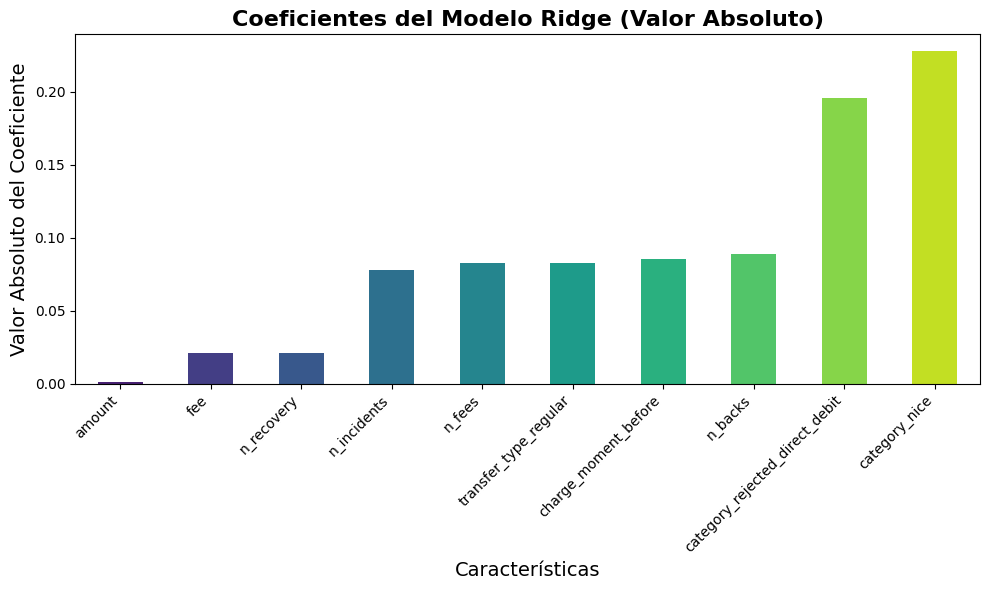

In [334]:
# Evaluación del modelo: calculamos el Error Cuadrático Medio (MSE) y el R^2
mse_ridge_train = mean_squared_error(y_train, y_train_pred_ridge) # MSE en entrenamiento
mse_ridge_test = mean_squared_error(y_test, y_test_pred_ridge) # MSE en prueba
r2score_ridge_train = ridge.score(X_train, y_train) # R^2 en entrenamiento
r2score_ridge_test = ridge.score(X_test, y_test) # R^2 en prueba
# Mostramos los resultados:
print('\nIntercepto del modelo:', ridge.intercept_)
print('\nCoeficientes del modelo Ridge:\n', ridge.coef_)
print('\nError Cuadrático Medio (MSE) en entrenamiento:', mse_ridge_train)
print('Error Cuadrático Medio (MSE) en prueba:', mse_ridge_test)
print('\nPuntaje R^2 en entrenamiento:', r2score_ridge_train)
print('Puntaje R^2 en prueba:', r2score_ridge_test)
# Graficamos los coeficientes ordenados por valor absoluto
plt.figure(figsize=(10, 6))
# Ordenar los coeficientes de menor a mayor (invirtiendo el orden)
coefs_ridge.sort_values(ascending=True).plot(kind='bar', color=sns.color_palette("viridis", n_colors=len(coefs_ridge)))

# Añadimos el título y etiquetas a los ejes
plt.title('Coeficientes del Modelo Ridge (Valor Absoluto)', fontsize=16, weight='bold')
plt.xlabel('Características', fontsize=14)
plt.ylabel('Valor Absoluto del Coeficiente', fontsize=14)
# Ajustamos las etiquetas del eje x para mejorar la legibilidad
plt.xticks(rotation=45, ha='right')
# Mostramos la gráfica con un diseño ajustado
plt.tight_layout() # Ajuste del espaciado para evitar solapamientos
plt.show()


Intercepto del modelo: 0.4894472385401939

Coeficientes del modelo Lasso:
 [ 0.00099031 -0.00369568 -0.09377649 -0.0471093   0.02558184  0.07754842
  0.          0.         -0.03449544  0.        ]

Error Cuadrático Medio (MSE) en entrenamiento: 0.1601582996551425
Error Cuadrático Medio (MSE) en prueba: 0.1606757860037199

Puntaje R^2 en entrenamiento: 0.3582499597215303
Puntaje R^2 en prueba: 0.35462521964499005


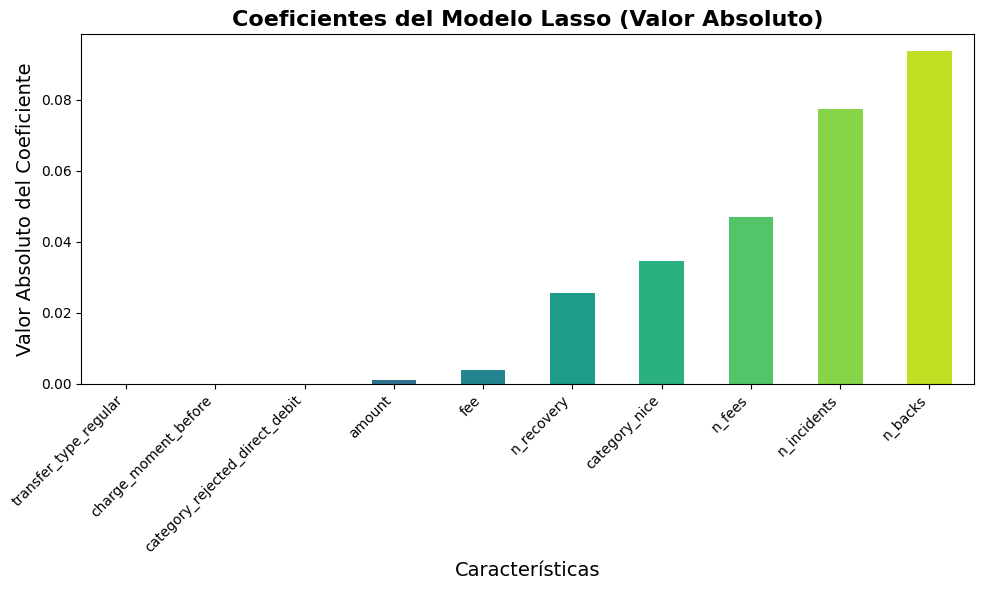

In [335]:
## Regresión Lasso
lasso = linear_model.Lasso(alpha=.02) # Inicializamos el regresor Lasso con una penalización de .02   #1
lasso.fit(X_train, y_train) # Ajustamos el modelo a los datos de entrenamiento
# Extraemos los coeficientes y los ordenamos en función de su valor absoluto
coefs_lasso = pd.Series(np.abs(lasso.coef_), index=feature_names).sort_values(ascending=False)
# Realizamos la predicción en los conjuntos de entrenamiento y prueba
y_train_pred_lasso = lasso.predict(X_train)
y_test_pred_lasso = lasso.predict(X_test)
# Evaluación del modelo: calculamos el Error Cuadrático Medio (MSE) y el R^2
mse_lasso_train = mean_squared_error(y_train, y_train_pred_lasso) # MSE en entrenamiento
mse_lasso_test = mean_squared_error(y_test, y_test_pred_lasso) # MSE en prueba
r2score_lasso_train = lasso.score(X_train, y_train) # R^2 en entrenamiento
r2score_lasso_test = lasso.score(X_test, y_test) # R^2 en prueba
# Mostramos los resultados:
print('\nIntercepto del modelo:', lasso.intercept_) # Imprimir el intercepto del modelo Lasso
print('\nCoeficientes del modelo Lasso:\n', lasso.coef_) # Imprimir los coeficientes del modelo Lasso
print('\nError Cuadrático Medio (MSE) en entrenamiento:', mse_lasso_train)
print('Error Cuadrático Medio (MSE) en prueba:', mse_lasso_test)
print('\nPuntaje R^2 en entrenamiento:', r2score_lasso_train)
print('Puntaje R^2 en prueba:', r2score_lasso_test)
# Graficamos los coeficientes ordenados por valor absoluto
plt.figure(figsize=(10, 6))
# Ordenar los coeficientes de menor a mayor (invirtiendo el orden)
coefs_lasso.sort_values(ascending=True).plot(kind='bar', color=sns.color_palette("viridis", n_colors=len(coefs_lasso)))
# Añadimos el título y etiquetas a los ejes
plt.title('Coeficientes del Modelo Lasso (Valor Absoluto)', fontsize=16, weight='bold')
plt.xlabel('Características', fontsize=14)
plt.ylabel('Valor Absoluto del Coeficiente', fontsize=14)
# Ajustamos las etiquetas del eje x para mejorar la legibilidad
plt.xticks(rotation=45, ha='right')
# Mostramos la gráfica con un diseño ajustado
plt.tight_layout() # Ajuste del espaciado para evitar solapamientos
plt.show()

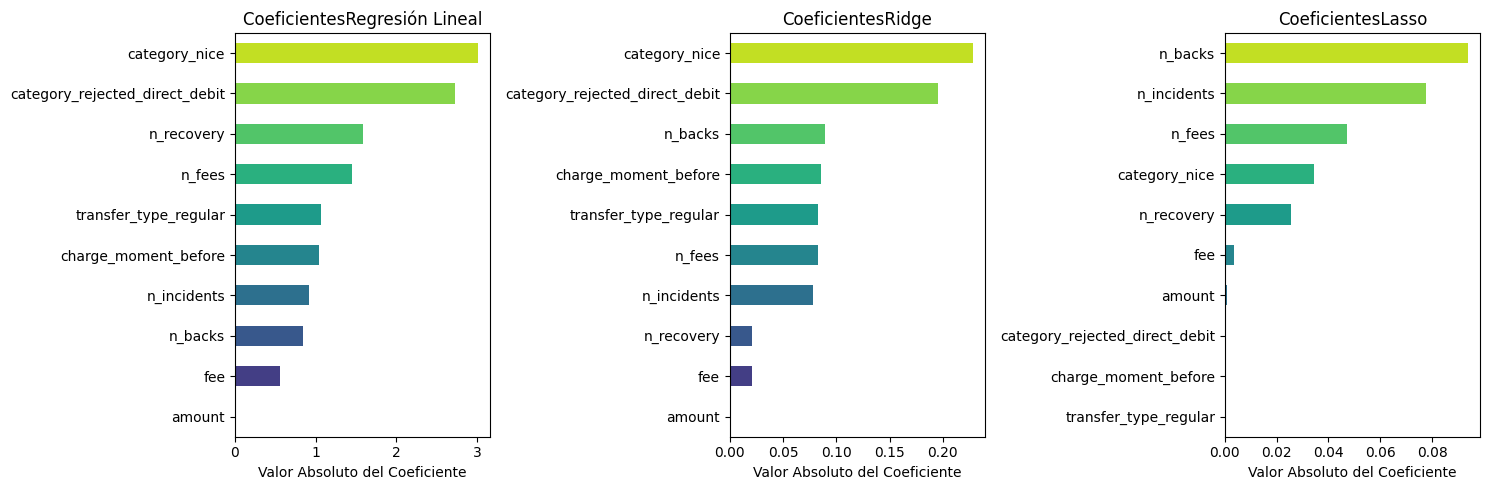

In [336]:
# Crear una figura de tamaño adecuado para visualizar los coeficientes
f = plt.figure(figsize=(15,5))
# Agregar los subgráficos
ax1 = f.add_subplot(131) # Primer gráfico para los coeficientes de la regresión lineal
ax2 = f.add_subplot(132) # Segundo gráfico para los coeficientes de Ridge
ax3 = f.add_subplot(133) # Tercer gráfico para los coeficientes de Lasso

# Graficar los coeficientes de cada modelo utilizando barras horizontales, ordenados de manera ascendente (menor a mayor)
coefs_clf.sort_values(ascending=True).plot(kind="barh", title='CoeficientesRegresión Lineal', ax=ax1, color=sns.color_palette("viridis",n_colors=len(coefs_clf))) # Coeficientes del modelo de regresión lineal
coefs_ridge.sort_values(ascending=True).plot(kind="barh", title='CoeficientesRidge', ax=ax2, color=sns.color_palette("viridis",n_colors=len(coefs_ridge))) # Coeficientes del modelo Ridge
coefs_lasso.sort_values(ascending=True).plot(kind="barh", title='CoeficientesLasso', ax=ax3, color=sns.color_palette("viridis",n_colors=len(coefs_lasso))) # Coeficientes del modelo Lasso
# Establecer etiquetas del eje X para cada gráfico
ax1.set_xlabel('Valor Absoluto del Coeficiente') # Etiqueta del eje X para el gráfico de regresión lineal
ax2.set_xlabel('Valor Absoluto del Coeficiente') # Etiqueta del eje X para el gráfico de Ridge
ax3.set_xlabel('Valor Absoluto del Coeficiente') # Etiqueta del eje X para el gráfico de Lasso
# Ajustar el espaciado entre los gráficos para que no se superpongan
plt.tight_layout()
# Mostrar la figura con los tres gráficos comparativos
plt.show()

In [337]:
print('Variables no importantes: {}'.format(coefs_lasso.index[coefs_lasso == 0].values)) # Imprimimos las variables con coeficientes cero (no importantes)
print('Variable más importante: {}'.format(coefs_lasso.index[-1])) #Imprimimos la variable más importante (con el coeficiente más alto)

Variables no importantes: ['transfer_type_regular' 'charge_moment_before'
 'category_rejected_direct_debit']
Variable más importante: category_rejected_direct_debit


In [338]:
# Cálculo de las métricas R² y MSE para cada modelo
scores = [
[r2score_train, r2score_test, r2score_train - r2score_test, mse_train,mse_test, mse_train - mse_test], # Regresión Lineal
[r2score_ridge_train, r2score_ridge_test, r2score_ridge_train - r2score_ridge_test, mse_ridge_train, mse_ridge_test, mse_ridge_train - mse_ridge_test], # Ridge
[r2score_lasso_train, r2score_lasso_test, r2score_lasso_train - r2score_lasso_test, mse_lasso_train, mse_lasso_test, mse_lasso_train - mse_lasso_test] # Lasso
]
# Creación del DataFrame con las métricas calculadas
df_scores = pd.DataFrame(scores,
columns=["R² Entrenamiento", "R² Prueba", "Δ R²(Entrenamiento - Prueba)",
"MSE Entrenamiento", "MSE Prueba", "Δ MSE(Entrenamiento - Prueba)"],
index=["Sin regularización", "Ridge", "Lasso"])
# Mostramos el DataFrame con los puntajes R² y MSE para comparar entre los modelos
df_scores # Visualizamos la comparación de puntajes R² y MSE entre los tres modelos, incluyendo sus diferencias

,R² Entrenamiento,R² Prueba,Δ R²(Entrenamiento - Prueba),MSE Entrenamiento,MSE Prueba,Δ MSE(Entrenamiento - Prueba)
Sin regularización,0.915592,0.916498,-0.000906,0.084408,0.083502,0.000906
Ridge,0.385746,0.384055,0.001691,0.153296,0.153349,-0.000053
Lasso,0.358250,0.354625,0.003625,0.160158,0.160676,-0.000517


In [339]:
# Ajustar el StandardScaler y transformar los datos de entrenamiento
scalerX = StandardScaler().fit(X_train)
X_train_std = scalerX.transform(X_train)
X_test_std = scalerX.transform(X_test)

# Crear un DataFrame para mostrar las estadísticas antes y después de la transformación
stats_before = {
'Mínimo': [np.min(X_train), np.min(X_test)],
'Máximo': [np.max(X_train), np.max(X_test)],
'Media': [np.mean(X_train), np.mean(X_test)],
'Varianza': [np.var(X_train, axis =0), np.var(X_test, axis =0)]
}
stats_after = {
'Mínimo': [np.min(X_train_std), np.min(X_test_std)],
'Máximo': [np.max(X_train_std), np.max(X_test_std)],
'Media': [np.mean(X_train_std), np.mean(X_test_std)],
'Varianza': [np.var(X_train_std, axis =0), np.var(X_test_std, axis =0)]
}

df_before = pd.DataFrame(stats_before, index=['Entrenamiento', 'Prueba'])
df_after = pd.DataFrame(stats_after, index=['Entrenamiento', 'Prueba'])
# Mostrar ambos DataFrames
print("\nEstadísticas antes de la transformación:")
df_before


Estadísticas antes de la transformación:


,Mínimo,Máximo,Media,Varianza
Entrenamiento,0.0,200.0,9.291832,amount 672.545287 f...
Prueba,0.0,200.0,9.332186,amount 663.823005 f...


In [340]:
print("\nEstadísticas después de la transformación:")
df_after


Estadísticas después de la transformación:


,Mínimo,Máximo,Media,Varianza
Entrenamiento,-3.179335,16.172474,-3.801388e-17,"[1.0, 1.0000000000000002, 1.0, 1.0000000000000..."
Prueba,-3.179335,13.802543,5.035404e-03,"[0.987030938003033, 0.9916591049299903, 1.0217..."


In [341]:
print("\nDespués de la transformación:")
# Observar los valores máximos, mínimos, promedio y varianza de nuestros predictores estandarizados
import pandas as pd
import numpy as np
# Crear una lista para almacenar los resultados
resultados_std = []
# Iterar sobre los predictores y calcular las estadísticas
for i, feat in enumerate(feature_names):
    minimo = np.min(X_train_std[:, i]) # Usamos X_train_std, que ya está estandarizado
    maximo = np.max(X_train_std[:, i])
    media = np.mean(X_train_std[:, i])
    varianza = np.var(X_train_std[:, i])
    # Añadir los resultados a la lista
    resultados_std.append([feat, minimo, maximo, media, varianza])

# Crear un DataFrame para mostrar los resultados
df_estadisticas_std = pd.DataFrame(resultados_std, columns=['Predictores' ,'Mínimo', 'Máximo', 'Media', 'Varianza'])
# Mostrar el DataFrame
df_estadisticas_std


Después de la transformación:


,Predictores,Mínimo,Máximo,Media,Varianza
0,amount,-3.179335,4.494144,-2.741373e-16,1.0
1,fee,-1.377545,2.828903,5.009474e-17,1.0
2,n_backs,-1.049600,6.861422,-6.254924e-17,1.0
3,n_fees,-0.871441,12.457162,-2.075749e-17,1.0
4,n_recovery,-0.417043,16.172474,2.380192e-17,1.0
5,n_incidents,-0.697748,11.519130,3.335037e-17,1.0
6,transfer_type_regular,-0.801328,1.247929,-5.535331e-17,1.0
7,charge_moment_before,-0.395922,2.525751,-5.068287e-17,1.0
8,category_nice,-1.191033,0.839608,3.252007e-17,1.0
9,category_rejected_direct_debit,-0.230388,4.340510,-5.203211e-17,1.0


In [342]:
# Entrenar modelos
clf_std = linear_model.LogisticRegression()
ridge_std = linear_model.Ridge(alpha=.3)
lasso_std = linear_model.Lasso(alpha=.02) #.3
clf_std.fit(X_train_std, y_train)
ridge_std.fit(X_train_std, y_train)
lasso_std.fit(X_train_std, y_train)
# Coeficientes de regresión
coefs_clf_std = pd.Series(np.abs(clf_std.coef_[0]), feature_names).sort_values()
coefs_ridge_std = pd.Series(np.abs(ridge_std.coef_), feature_names).sort_values()
coefs_lasso_std = pd.Series(np.abs(lasso_std.coef_), feature_names).sort_values()

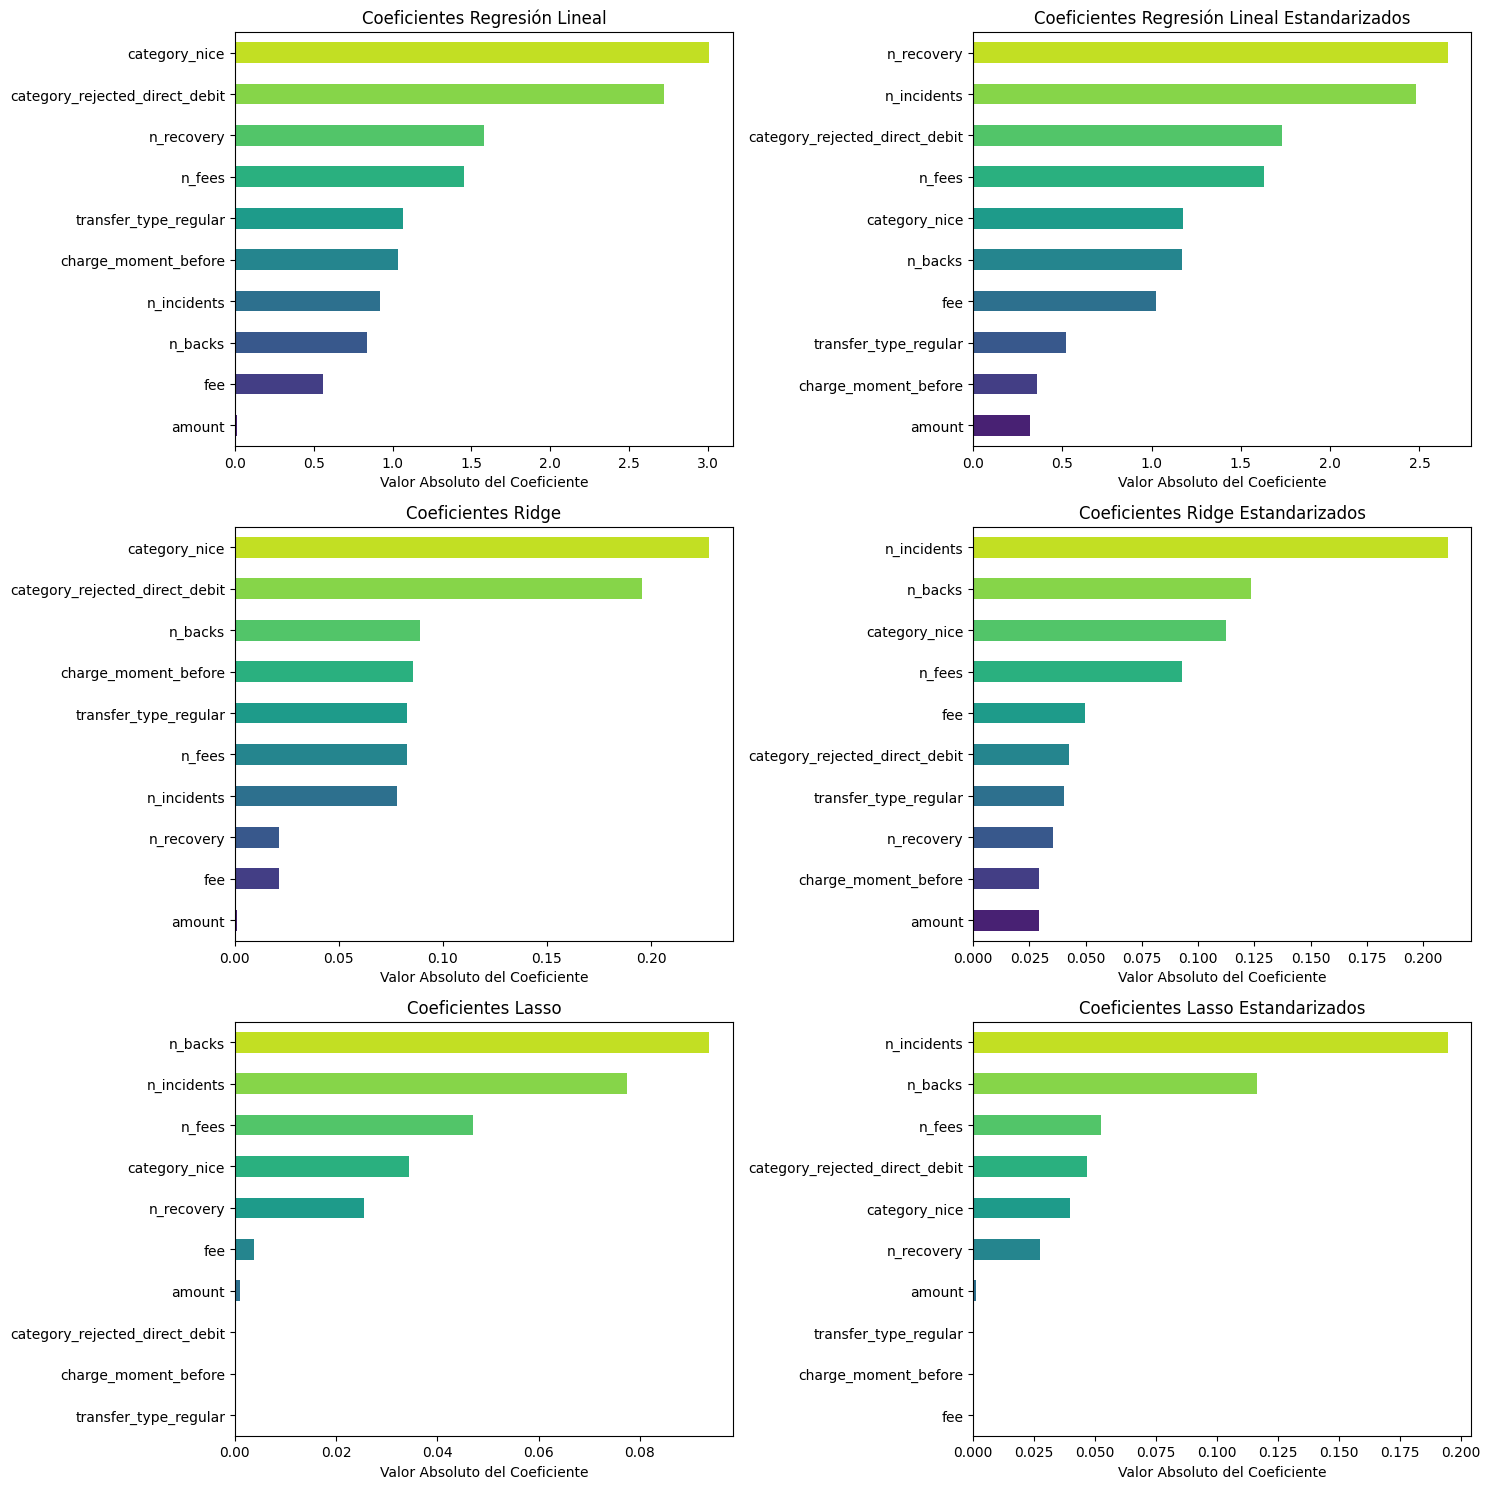

In [343]:
# Crear una figura de tamaño adecuado para visualizar los coeficientes en una disposición de 3x2
f = plt.figure(figsize=(15, 15))
# Agregar los subgráficos para cada modelo y cada tipo de coeficiente
ax1 = f.add_subplot(321) # Gráfico de coeficientes de regresión lineal
ax2 = f.add_subplot(322) # Gráfico de coeficientes estandarizados de regresión lineal
ax3 = f.add_subplot(323) # Gráfico de coeficientes de Ridge
ax4 = f.add_subplot(324) # Gráfico de coeficientes estandarizados de Ridge
ax5 = f.add_subplot(325) # Gráfico de coeficientes de Lasso
ax6 = f.add_subplot(326) # Gráfico de coeficientes estandarizados de Lasso
# Graficar los coeficientes de cada modelo utilizando barras horizontales, ordenados de menor a mayor
coefs_clf.sort_values(ascending=True).plot(
kind="barh", title='Coeficientes Regresión Lineal', ax=ax1,
color=sns.color_palette("viridis", n_colors=len(coefs_clf)))
coefs_clf_std.sort_values(ascending=True).plot(
kind="barh", title='Coeficientes Regresión Lineal Estandarizados', ax=ax2,
color=sns.color_palette("viridis", n_colors=len(coefs_clf_std)))
coefs_ridge.sort_values(ascending=True).plot(
kind="barh", title='Coeficientes Ridge', ax=ax3,
color=sns.color_palette("viridis", n_colors=len(coefs_ridge))
)
coefs_ridge_std.sort_values(ascending=True).plot(
kind="barh", title='Coeficientes Ridge Estandarizados', ax=ax4,
color=sns.color_palette("viridis", n_colors=len(coefs_ridge_std))
)
coefs_lasso.sort_values(ascending=True).plot(
kind="barh", title='Coeficientes Lasso', ax=ax5,
color=sns.color_palette("viridis", n_colors=len(coefs_lasso))
)
coefs_lasso_std.sort_values(ascending=True).plot(
kind="barh", title='Coeficientes Lasso Estandarizados', ax=ax6,
color=sns.color_palette("viridis", n_colors=len(coefs_lasso_std))
)
# Etiquetas del eje X para cada gráfico
for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
    ax.set_xlabel('Valor Absoluto del Coeficiente')

# Ajustar el espaciado entre los gráficos para que no se superpongan
plt.tight_layout()
# Mostrar la figura con los seis gráficos comparativos
plt.show()

In [344]:
print('Variables no importantes:')
print('\nAntes de la transformación: {}'.format(sorted(coefs_lasso.index[coefs_lasso == 0].values)))
print('\nDespués de la transformación: {}'.format(sorted(coefs_lasso_std.index[coefs_lasso_std == 0].values)))
print('\nVariable más importante:')
print('\nAntes de la transformación: {}'.format(coefs_lasso.index[-1]))
print('\nDespués de la transformación: {}'.format(coefs_lasso_std.index[-1]))

Variables no importantes:

Antes de la transformación: ['category_rejected_direct_debit', 'charge_moment_before', 'transfer_type_regular']

Después de la transformación: ['charge_moment_before', 'fee', 'transfer_type_regular']

Variable más importante:

Antes de la transformación: category_rejected_direct_debit

Después de la transformación: n_incidents


In [345]:
# Evaluar los modelos y almacenar los resultados en un diccionario
scores = {
    'Modelo': ['Regresión Lineal', 'Regresión Ridge', 'Regresión Lasso',
    'Regresión Logistica (Estandarizada)', 'Regresión Ridge(Estandarizada)', 'Regresión Lasso (Estandarizada)'],
    'R^2': [
        clf.score(X_test, y_test),
        ridge.score(X_test, y_test),
        lasso.score(X_test, y_test),
        clf_std.score(X_test_std, y_test),
        ridge_std.score(X_test_std, y_test),
        lasso_std.score(X_test_std, y_test)
    ]
}
# Crear el DataFrame
df_scores = pd.DataFrame(scores)
# Mostrar el DataFrame con los resultados
df_scores

,Modelo,R^2
0,Regresión Lineal,0.916498
1,Regresión Ridge,0.384055
2,Regresión Lasso,0.354625
3,Regresión Logistica (Estandarizada),0.916498
4,Regresión Ridge(Estandarizada),0.384057
5,Regresión Lasso (Estandarizada),0.370768


In [346]:
# Parámetros
n_alphas = 100
alphas = np.logspace(-4, 4, n_alphas)
np.random.seed(42)
np.random.shuffle(alphas)
# Inicialización de listas para almacenar coeficientes, puntajes R^2 y MSE
coefs_ridge = []
r2_ridge = []
mse_ridge = []
coefs_lasso = []
r2_lasso = []
mse_lasso = []

# Para Ridge
for l in alphas:
    regr_ridge = linear_model.Ridge(alpha=l, tol = 0.01) # Crear un regresorRidge
    regr_ridge.fit(X_train_std, y_train) # Ajustar el modelo
    coefs_ridge.append(regr_ridge.coef_)
    r2_ridge.append(regr_ridge.score(X_test_std, y_test)) # Puntaje R^2 para cada alpha
    mse_ridge.append(mean_squared_error(y_test, regr_ridge.predict(X_test_std))) # MSE para cada alpha

# Para Lasso
for l in alphas:
    regr_lasso = linear_model.Lasso(alpha=l, tol = 0.01) # Crear un regresorLasso
    regr_lasso.fit(X_train_std, y_train) # Ajustar el modelo
    coefs_lasso.append(regr_lasso.coef_)
    r2_lasso.append(regr_lasso.score(X_test_std, y_test)) # Puntaje R^2 para cada alpha
    mse_lasso.append(mean_squared_error(y_test, regr_lasso.predict(X_test_std))) # MSE para cada alpha

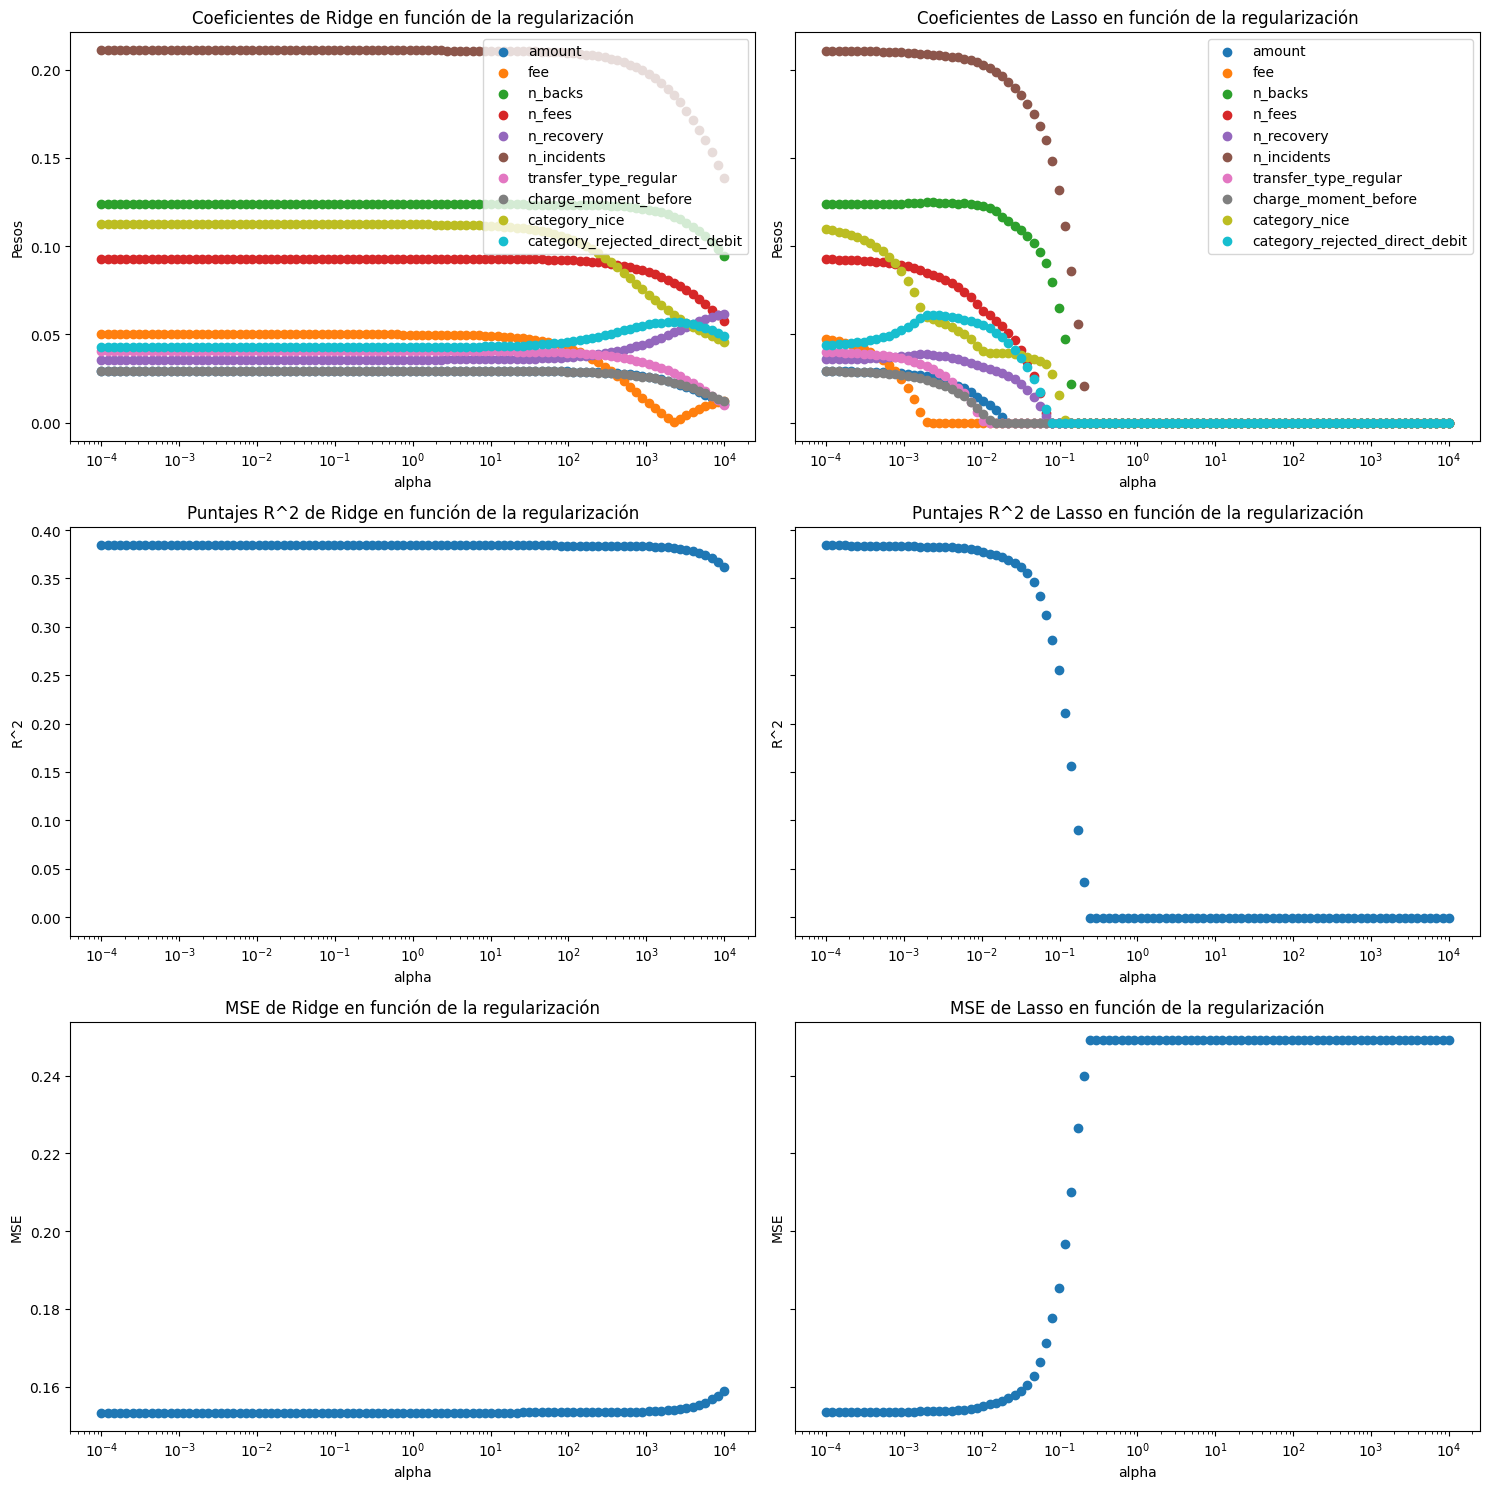

In [347]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15), sharey='row')
# Coeficientes de Ridge
for coef in np.abs(coefs_ridge).T:
    axs[0,0].scatter(alphas, coef)
axs[0,0].set_xscale('log')
axs[0,0].set_title('Coeficientes de Ridge en función de la regularización')
axs[0,0].axis('tight')
axs[0,0].set_xlabel('alpha')
axs[0,0].set_ylabel('Pesos')
axs[0,0].legend(feature_names)

# Coeficientes de Lasso
for coef in np.abs(coefs_lasso).T:
    axs[0,1].scatter(alphas, coef)
axs[0,1].set_xscale('log')
axs[0,1].set_title('Coeficientes de Lasso en función de la regularización')
axs[0,1].axis('tight')
axs[0,1].set_xlabel('alpha')
axs[0,1].set_ylabel('Pesos')
axs[0,1].legend(feature_names)
# Scores de Ridge
axs[1,0].scatter(alphas, r2_ridge)
axs[1,0].set_xscale('log')
axs[1,0].set_title('Puntajes R^2 de Ridge en función de la regularización')
axs[1,0].axis('tight')
axs[1,0].set_xlabel('alpha')
axs[1,0].set_ylabel('R^2')
# Scores de Lasso
axs[1,1].scatter(alphas, r2_lasso)
axs[1,1].set_xscale('log')
axs[1,1].set_title('Puntajes R^2 de Lasso en función de la regularización')
axs[1,1].axis('tight')
axs[1,1].set_xlabel('alpha')
axs[1,1].set_ylabel('R^2')
# MSE de Ridge
axs[2,0].scatter(alphas, mse_ridge)
axs[2,0].set_xscale('log')
axs[2,0].set_title('MSE de Ridge en función de la regularización')
axs[2,0].axis('tight')
axs[2,0].set_xlabel('alpha')
axs[2,0].set_ylabel('MSE')
# MSE de Lasso
axs[2,1].scatter(alphas, mse_lasso)
axs[2,1].set_xscale('log')
axs[2,1].set_title('MSE de Lasso en función de la regularización')
axs[2,1].axis('tight')
axs[2,1].set_xlabel('alpha')
axs[2,1].set_ylabel('MSE')
plt.tight_layout()
plt.show()

In [348]:
# Selección de alpha óptimo para Ridge basado en R^2
max_index_ridge_r2 = np.argmax(r2_ridge) # Encontrar el índice del máximo R^2
best_alpha_ridge_r2 = alphas[max_index_ridge_r2] # Encontrar el alpha correspondiente
best_r2_ridge = r2_ridge[max_index_ridge_r2] # Puntaje R^2 correspondiente al máximo
# Selección de alpha óptimo para Ridge basado en MSE
min_index_ridge_mse = np.argmin(mse_ridge) # Encontrar el índice del mínimo MSE
best_alpha_ridge_mse = alphas[min_index_ridge_mse] # Encontrar el alpha correspondiente
best_mse_ridge = mse_ridge[min_index_ridge_mse] # Puntaje MSE correspondiente al mínimo
# Selección de alpha óptimo para Lasso basado en R^2
max_index_lasso_r2 = np.argmax(r2_lasso) # Encontrar el índice del máximo R^2
best_alpha_lasso_r2 = alphas[max_index_lasso_r2] # Encontrar el alpha correspondiente
best_r2_lasso = r2_lasso[max_index_lasso_r2] # Puntaje R^2 correspondiente al máximo
# Selección de alpha óptimo para Lasso basado en MSE
min_index_lasso_mse = np.argmin(mse_lasso) # Encontrar el índice del mínimo MSE
best_alpha_lasso_mse = alphas[min_index_lasso_mse] # Encontrar el alpha correspondiente
best_mse_lasso = mse_lasso[min_index_lasso_mse] # Puntaje MSE correspondiente al mínimo
# Crear un DataFrame con los resultados
resultados = {
    'Modelo': ['Ridge', 'Lasso'],
    'Índice del mejor R^2': [max_index_ridge_r2, max_index_lasso_r2],'Mejor alpha encontrado (R^2)': [best_alpha_ridge_r2, best_alpha_lasso_r2],
    'Puntaje R^2 máximo obtenido': [best_r2_ridge, best_r2_lasso],
    'Índice del mejor MSE': [min_index_ridge_mse, min_index_lasso_mse],
    'Mejor alpha encontrado (MSE)': [best_alpha_ridge_mse, best_alpha_lasso_mse],
    'Puntaje MSE mínimo obtenido': [best_mse_ridge, best_mse_lasso]
}
# Crear DataFrame
df_resultados = pd.DataFrame(resultados)
# Mostrar el DataFrame con los resultados
df_resultados

,Modelo,Índice del mejor R^2,Mejor alpha encontrado (R^2),Puntaje R^2 máximo obtenido,Índice del mejor MSE,Mejor alpha encontrado (MSE),Puntaje MSE mínimo obtenido
0,Ridge,9,0.0001,0.384057,9,0.0001,0.153348
1,Lasso,9,0.0001,0.384024,9,0.0001,0.153357


In [349]:
# Crear un diccionario con los datos en una sola fila
data = {
    'R2_Entrenamiento': [r2score_train],
    'R2_Prueba': [r2score_test],
    'Diferencia_R2': [r2score_train - r2score_test]
}
# Crear el DataFrame
df_r2_scores = pd.DataFrame(data)
# Mostrar el DataFrame
df_r2_scores

,R2_Entrenamiento,R2_Prueba,Diferencia_R2
0,0.915592,0.916498,-0.000906


In [350]:
best_alpha_lasso_r2 = 0.3
lasso = linear_model.Lasso(alpha=best_alpha_lasso_r2)
lasso.fit(X_train_std, y_train)
coefs = pd.Series(np.abs(lasso.coef_), feature_names).sort_values()
print(coefs)

amount                            0.0
fee                               0.0
n_backs                           0.0
n_fees                            0.0
n_recovery                        0.0
n_incidents                       0.0
transfer_type_regular             0.0
charge_moment_before              0.0
category_nice                     0.0
category_rejected_direct_debit    0.0
dtype: float64


In [351]:
df = pd.DataFrame(X_train_std, columns=feature_names)
df['targ'] = y_train
df.head()

,amount,fee,n_backs,n_fees,n_recovery,n_incidents,transfer_type_regular,charge_moment_before,category_nice,category_rejected_direct_debit,targ
0,-0.904283,-1.377545,-0.330416,-0.871441,-0.417043,1.523503,-0.801328,-0.395922,-1.191033,-0.230388,1.0
1,-1.289885,-1.377545,-1.049600,-0.871441,-0.417043,0.042669,-0.801328,-0.395922,-1.191033,-0.230388,0.0
2,0.638124,-1.377545,-1.049600,-0.871441,-0.417043,-0.327539,1.247929,-0.395922,-1.191033,-0.230388,1.0
3,0.638124,-1.377545,1.107952,0.905706,0.767922,0.783086,-0.801328,-0.395922,-1.191033,-0.230388,1.0
4,0.638124,-1.377545,-0.330416,0.017133,0.175439,0.412878,1.247929,-0.395922,-1.191033,-0.230388,1.0


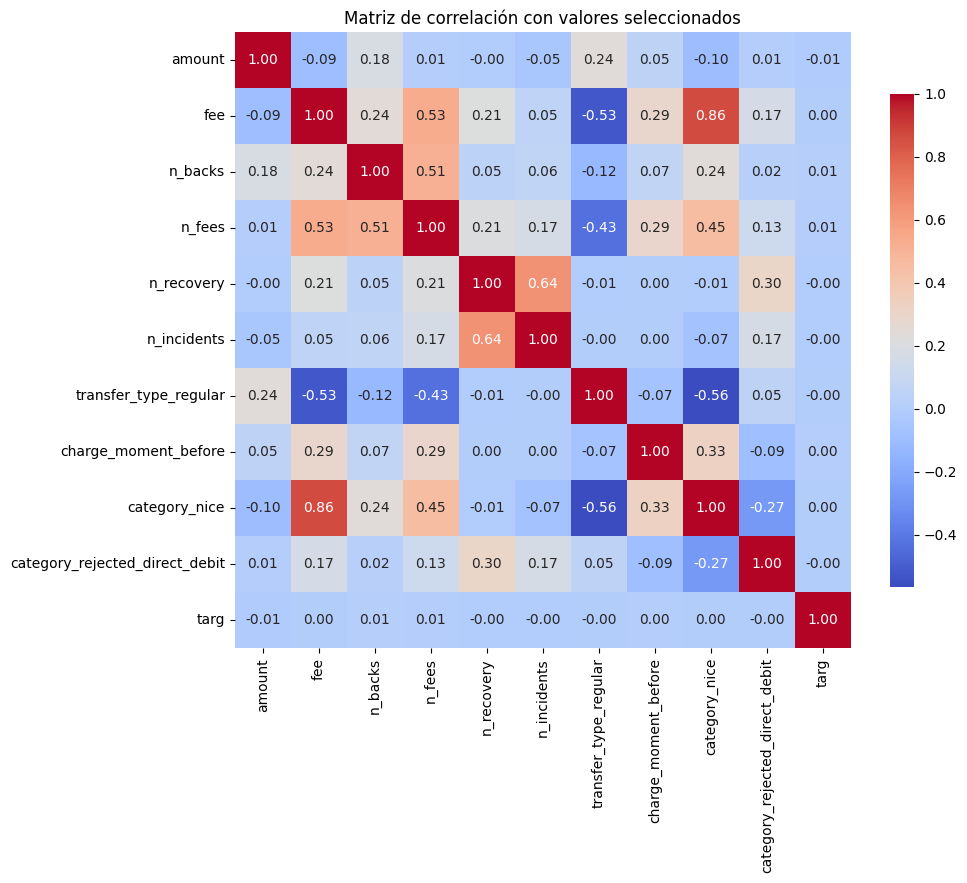

In [352]:
# Crear una matriz de correlación para las variables de interés
correlacion = df.corr()
# Configurar el tamaño de la figura
plt.figure(figsize=(10, 8))
# Crear el mapa de calor con valores numéricos sobre cada cuadro
sns.heatmap(correlacion, annot=True, cmap='coolwarm', fmt=".2f", square=True, cbar_kws={'shrink': .8})
# Añadir título a la gráfica
plt.title('Matriz de correlación con valores seleccionados')
# Mostrar la gráfica
plt.show()

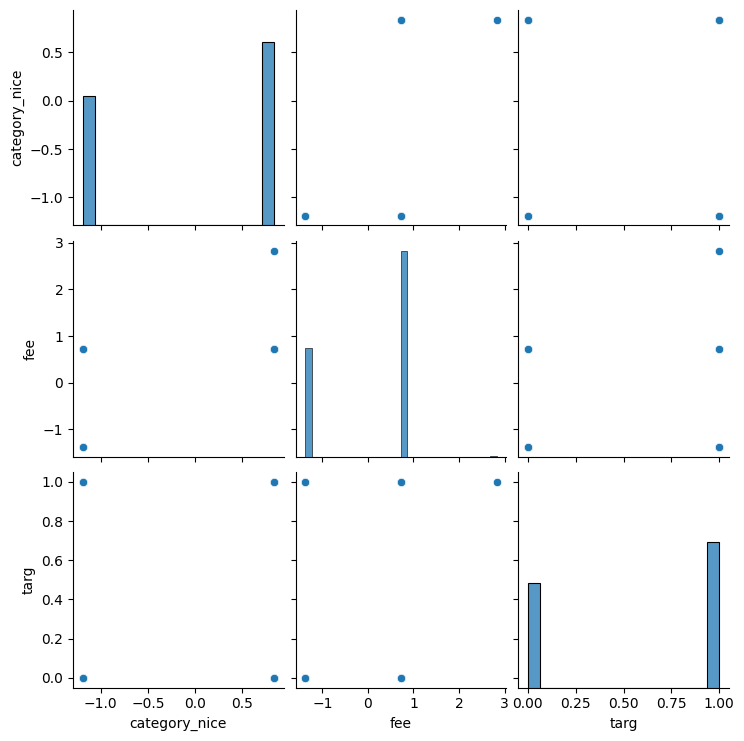

In [353]:
#sns.pairplot(df[['AGE', 'PTRATIO', 'LSTAT', 'CHAS', 'RM', 'targ']])
sns.pairplot(df[['category_nice', 'fee','targ']])

In [354]:
import sklearn.feature_selection as fs
import numpy as np
# Crear el selector de características
selector = fs.SelectKBest(score_func=fs.f_regression, k=5)
# Aplicar el selector a los datos de entrenamiento y prueba
X_new_train = selector.fit_transform(X_train, y_train)
X_new_test = selector.transform(X_test)
# Obtener los índices de las características seleccionadas
selected_features_indices = selector.get_support(indices=True)
# Obtener los nombres de características relevantes y no importantes
relevant_features = np.array(feature_names)[selected_features_indices]
non_important_features = np.array(feature_names)[np.logical_not(selector.get_support())]
print('Variables no importantes: {}'.format(non_important_features))
print('\nVariables relevantes: {}'.format(relevant_features))

Variables no importantes: ['amount' 'fee' 'n_fees' 'transfer_type_regular' 'charge_moment_before']

Variables relevantes: ['n_backs' 'n_recovery' 'n_incidents' 'category_nice'
 'category_rejected_direct_debit']


In [355]:
X_new_train.shape

(25673, 5)

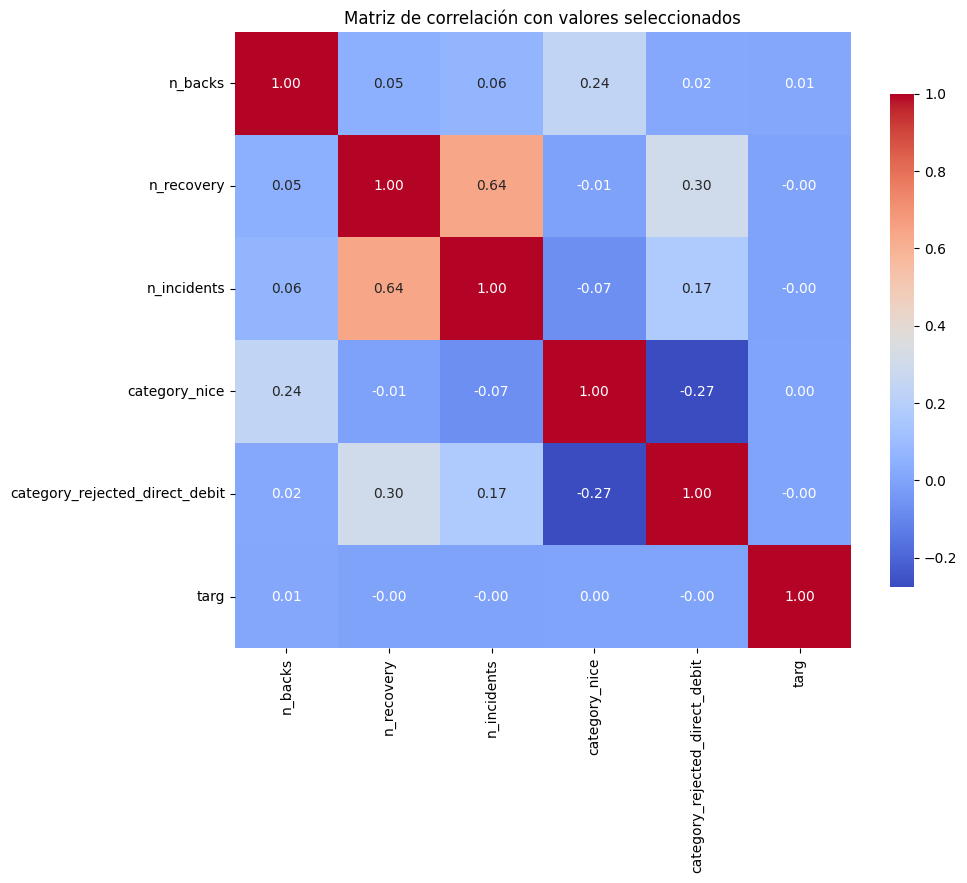

In [356]:
# Crear una matriz de correlación para las variables de interés
correlacion = df[relevant_features.tolist() + ['targ']].corr()
# Configurar el tamaño de la figura
plt.figure(figsize=(10, 8))
# Crear el mapa de calor con valores numéricos sobre cada cuadro
sns.heatmap(correlacion, annot=True, cmap='coolwarm', fmt=".2f", square=True, cbar_kws={'shrink': .8})
# Añadir título a la gráfica
plt.title('Matriz de correlación con valores seleccionados')
# Mostrar la gráfica
plt.show()

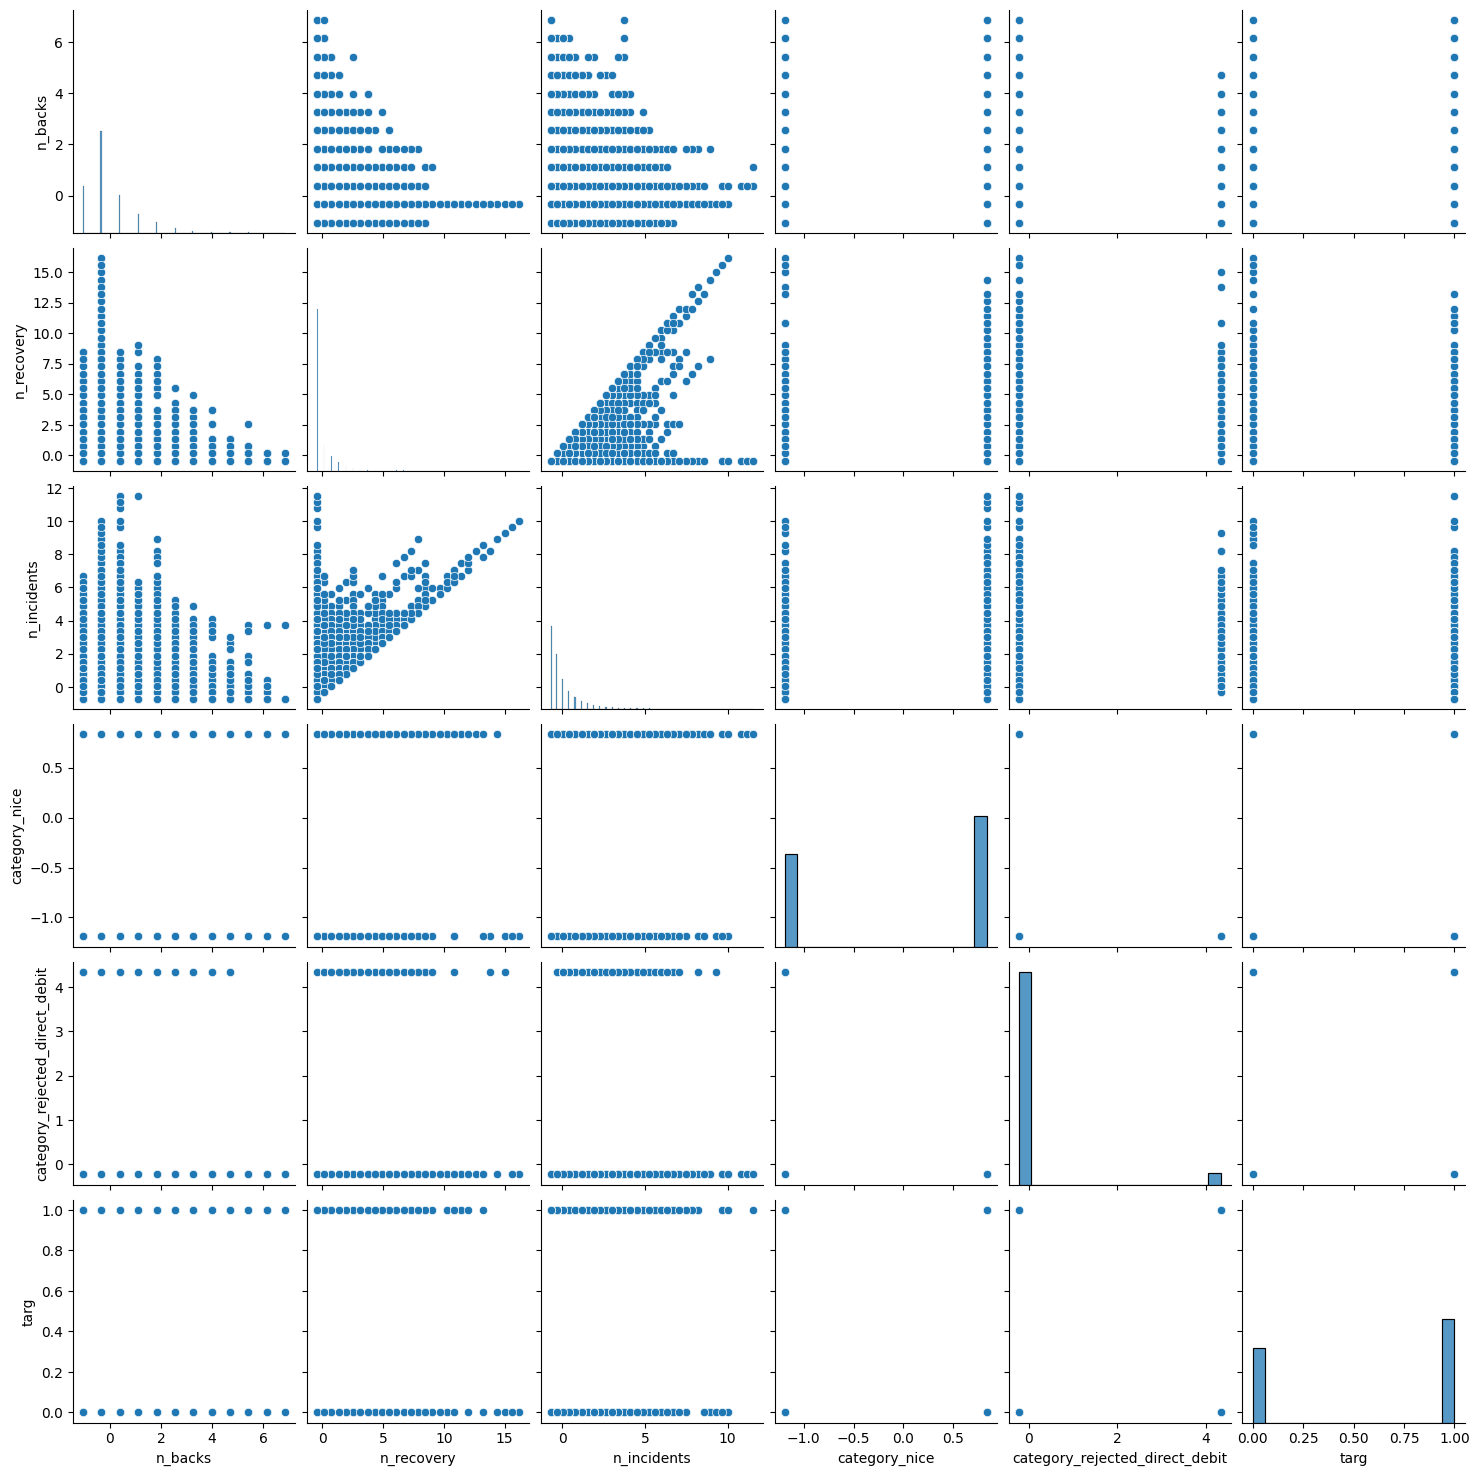

In [357]:
sns.pairplot(df[relevant_features.tolist() + ['targ']])